In [1]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from trustee import ClassificationTrustee
from trustee.report.trust import TrustReport

plt.rcParams['font.family'] = 'sans-serif'

In [2]:
# Base path where all method folders are
METHOD = "pensieve"
base_path = f'./ABR_Separated/{METHOD}/'

# Collect all merged CSVs
all_dfs = []

print("Loading CSV files...")

# Loop through each ABR method folder
path_pattern = os.path.join(base_path, '*.csv')  # Match all CSVs under each method folder
for file_path in glob(path_pattern):
    try:
        df = pd.read_csv(file_path, dtype=str)
        all_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

Loading CSV files...


In [3]:
# Combine all data
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

Combining CSVs into one DataFrame...
Total rows loaded: 338531


### If we're looking only at the downsampled data ignore the above and do the following:

In [4]:
data = pd.read_csv("downsampled_format_data.csv")
print(data.columns)

Index(['time (ns GMT)', 'session_id', 'video_ts_x', 'format_x', 'size_x',
       'ssim_index_x', 'cwnd_x', 'in_flight_x', 'min_rtt_x', 'rtt_x',
       'delivery_rate_x', 'index_y', 'expt_id_y', 'channel_y', 'event_x',
       'buffer_x', 'cum_rebuf_x', 'source_dataset_y', 'index_x', 'expt_id_x',
       'channel_x', 'event_y', 'buffer_y', 'cum_rebuf_y', 'source_dataset_x',
       'index_y.1', 'expt_id_y.1', 'channel_y.1', 'video_ts_y', 'format_y',
       'size_y', 'ssim_index_y', 'cwnd_y', 'in_flight_y', 'min_rtt_y', 'rtt_y',
       'delivery_rate_y', 'source_dataset_y.1', 'video_ts', 'format', 'size',
       'ssim_index', 'cwnd', 'in_flight', 'min_rtt', 'rtt', 'delivery_rate',
       'event', 'buffer', 'cum_rebuf'],
      dtype='object')


In [5]:
# Drop columns
non_mpc_columns = [
    'time (ns GMT)', 'session_id', 'index_x', 'expt_id_x',
    'channel_x', 'video_ts', 'ssim_index', 'source_dataset_x', 'index_y',
    'expt_id_y', 'channel_y', 'source_dataset_y',
# need to drop these if working with downsampled data
    'video_ts_x',
       'format_x', 'size_x', 'ssim_index_x', 'cwnd_x', 'in_flight_x',
       'min_rtt_x', 'rtt_x', 'delivery_rate_x', 'event_x', 'buffer_x',
       'cum_rebuf_x', 'event_y', 'buffer_y', 'cum_rebuf_y', 'index_y.1',
       'expt_id_y.1', 'channel_y.1', 'video_ts_y', 'format_y', 'size_y',
       'ssim_index_y', 'cwnd_y', 'in_flight_y', 'min_rtt_y', 'rtt_y',
       'delivery_rate_y', 'source_dataset_y.1'
]

data = data.drop(columns=non_mpc_columns)

In [6]:
# Rename format_x to PlaybackQuality
data["PlaybackQuality"] = data["format"]
data.drop(columns=['format'], inplace=True)

In [7]:
# Encode event_x labels as integers
event_labels = data["event"].unique()
event_to_index = {q: i for i, q in enumerate(event_labels)}
data['event'] = data['event'].map(event_to_index)

In [8]:
# Convert columns to numeric"
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    if col == 'PlaybackQuality':
        continue
    data[col] = pd.to_numeric(data[col], errors='ignore')

# Drop rows with NaN
data = data.dropna()

print(data.head())

Converting columns to numeric: 100%|███████████| 10/10 [00:00<00:00, 849.46it/s]

      size  cwnd  in_flight  min_rtt     rtt  delivery_rate  event  buffer  \
0   832781   216        216   173493  185986        1563568      0   0.000   
1   830234   233          0   173493  188070        1742417      1   1.869   
2  1209588   239          0   173493  194522        1754011      2   1.585   
3   959666   246          0   173493  186869        1912002      2   2.837   
4   690967   249          0   173493  189618        1883353      2   4.338   

   cum_rebuf PlaybackQuality  
0       0.00     1280x720-20  
1       0.86     1280x720-20  
2       0.86     1280x720-20  
3       0.86     1280x720-20  
4       0.86     1280x720-20  


In [9]:
# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

class_counts = data["PlaybackQuality"].value_counts()
max_count = max(class_counts.values)
class_weight = {k: max_count / v for k, v in class_counts.items()}

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']

In [10]:
# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
# clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)

clf.fit(X_train, y_train)

# Evaluate
print("Evaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...
Evaluating model...


In [11]:
target_names = [str(cls) for cls in le.classes_]
target_names

['1280x720-20',
 '1280x720-22',
 '1280x720-24',
 '1280x720-26',
 '1920x1080-22',
 '1920x1080-24',
 '426x240-26',
 '640x360-24',
 '640x360-26',
 '854x480-22',
 '854x480-24',
 '854x480-26']

Classification Report:
              precision    recall  f1-score   support

 1280x720-20       0.92      0.96      0.94      4979
 1280x720-22       0.60      0.40      0.48       783
 1280x720-24       0.39      0.31      0.35       934
 1280x720-26       0.49      0.52      0.50      1146
1920x1080-22       0.93      0.98      0.95      5028
1920x1080-24       0.58      0.15      0.24       216
  426x240-26       0.70      0.54      0.61       798
  640x360-24       0.62      0.73      0.67      1514
  640x360-26       0.66      0.84      0.74      1229
  854x480-22       0.34      0.23      0.27       271
  854x480-24       0.47      0.50      0.48       695
  854x480-26       0.20      0.03      0.05       345

    accuracy                           0.78     17938
   macro avg       0.58      0.51      0.52     17938
weighted avg       0.76      0.78      0.76     17938



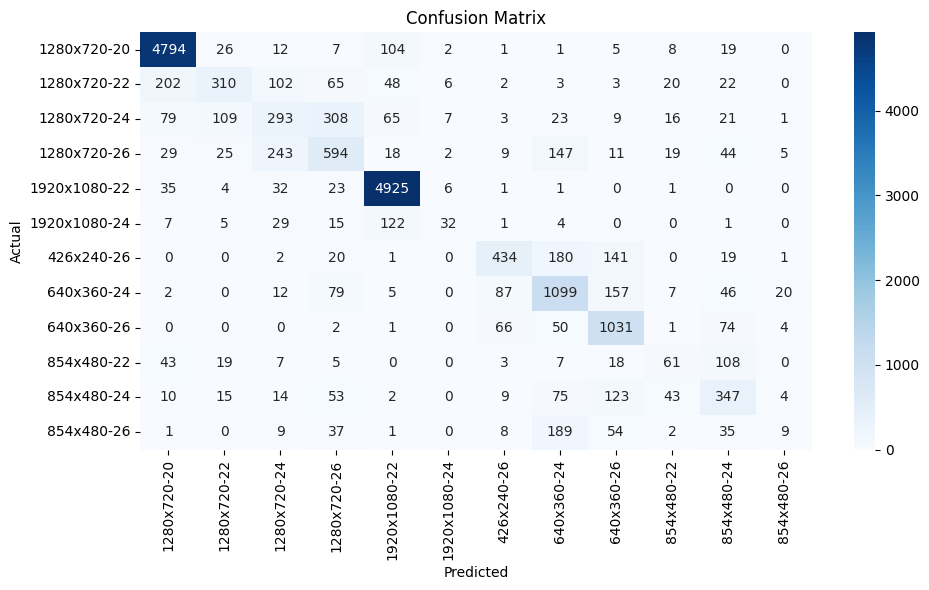

In [12]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))
# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

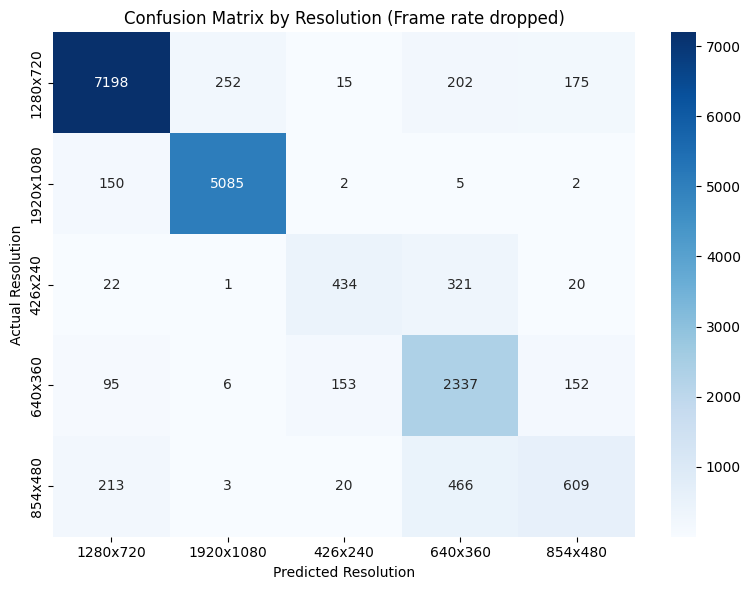

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = [str(c) for c in le.classes_]

def get_resolution(label):
    return label.split('-')[0]

# Convert y_test and y_pred from indices to string labels
y_test_labels = [labels[y] for y in y_test]
y_pred_labels = [labels[y] for y in y_pred]

# Extract resolution only
y_test_res = [get_resolution(label) for label in y_test_labels]
y_pred_res = [get_resolution(label) for label in y_pred_labels]

unique_res = sorted(set(y_test_res) | set(y_pred_res))

cm_res = confusion_matrix(y_test_res, y_pred_res, labels=unique_res)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_res, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_res, yticklabels=unique_res)
plt.title("Confusion Matrix by Resolution (Frame rate dropped)")
plt.xlabel("Predicted Resolution")
plt.ylabel("Actual Resolution")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import precision_recall_fscore_support

# Map integer labels to strings
y_test_labels = [labels[y] for y in y_test]
y_pred_labels = [labels[y] for y in y_pred]

# Extract resolutions only
y_test_res = [get_resolution(label) for label in y_test_labels]
y_pred_res = [get_resolution(label) for label in y_pred_labels]

unique_res = sorted(set(y_test_res) | set(y_pred_res))

# Calculate precision, recall, f1 per resolution
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_res, y_pred_res, labels=unique_res, zero_division=0
)

# Print nicely
print(f"{'Resolution':15} {'Precision':>9} {'Recall':>9} {'F1-Score':>9} {'Support':>9}")
for i, res in enumerate(unique_res):
    print(f"{res:15} {precision[i]:9.2f} {recall[i]:9.2f} {f1[i]:9.2f} {support[i]:9d}")


Resolution      Precision    Recall  F1-Score   Support
1280x720             0.94      0.92      0.93      7842
1920x1080            0.95      0.97      0.96      5244
426x240              0.70      0.54      0.61       798
640x360              0.70      0.85      0.77      2743
854x480              0.64      0.46      0.54      1311


In [15]:
from sklearn.metrics import f1_score

# Overall (macro) F1 score by resolution
overall_f1 = f1_score(y_test_res, y_pred_res, average='macro')

print(f"\nOverall Macro F1-score (by resolution): {overall_f1:.4f}")


Overall Macro F1-score (by resolution): 0.7609


# TRUSTEE

In [ ]:
importances = clf.feature_importances_
feat_names = X.columns

for name, imp in sorted(zip(feat_names, importances), key=lambda x: -x[1])[:20]:
    print(f"{name}: {imp:.4f}")

size: 0.1673
min_rtt: 0.1614
cum_rebuf: 0.1466
delivery_rate: 0.1422
buffer: 0.1271
rtt: 0.1217
cwnd: 0.1174
in_flight: 0.0152
event: 0.0011


In [ ]:
trustee = ClassificationTrustee(expert=clf)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)
dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(X_test)

print("Fidelity to original model:")
print(classification_report(y_pred, dt_y_pred))

print("Accuracy vs. true labels:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=42) as expert model
Expert model score: 0.9880704817933416
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 47823 points from training dataset with (159411, 159411) entries
Student model 0-0 trained with depth 36 and 10734 leaves:
Student model score: 0.45012170709962884
Student model 0-0 fidelity: 0.45012170709962884
########## Inner-loop Iteration 1/50 ##########
Sampling 47823 points from training dataset with (173758, 173758) entries
Student model 0-1 trained with depth 35 and 10583 leaves:
Student model score: 0.4670129356963721
Student model 0-1 fidelity: 0.4670129356963721
########## Inner-loop Iteration 2/50 ##########
Sampling 47823 points from training dataset with (188105, 188105) entr

KeyboardInterrupt: 

In [ ]:
OUTPUT_PATH = "out"
REPORT_PATH = f"{OUTPUT_PATH}/report/trust_report.obj"

if os.path.exists(REPORT_PATH):
    print(f"Loading trust report from {REPORT_PATH}...")
    trust_report = TrustReport.load(REPORT_PATH)
    print("Done!")
else:
    trust_report = TrustReport(
        blackbox=clf,
        X=X,
        y=y,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        max_iter=5,
        num_pruning_iter=5,
        train_size=0.7,
        trustee_num_iter=10,
        trustee_num_stability_iter=5,
        trustee_sample_size=0.3,
        analyze_branches=True,
        analyze_stability=True,
        top_k=10,
        verbose=True,
        class_names=list(le.classes_),
        feature_names=list(X.columns),
        is_classify=True,
    )

print(trust_report)
trust_report.save(OUTPUT_PATH)

Loading trust report from out/report/trust_report.obj...
Done!

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                    Classification Trust Report                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                       +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+                        |
|           

# AQUA

In [ ]:
concept_dict = {
    'Rebuffering': ['cum_rebuf'],
    'Latency': ['min_rtt', 'rtt'],
    'Network': ['cwnd', 'in_flight', 'delivery_rate'],
    'VideoQuality': ['size'],
    'Buffer': ['buffer'],
    'ClientEvent': ['event'],
}

for concept, features in concept_dict.items():
    concept_dict[concept] = [f for f in features if f in X.columns]

In [ ]:
def make_concept_features(X, concept_dict, agg='mean'):
    X_concepts = pd.DataFrame(index=X.index)
    for concept, cols in concept_dict.items():
        valid_cols = [col for col in cols if col in X.columns]
        if not valid_cols:
            continue
        if agg == 'mean':
            X_concepts[concept] = X[valid_cols].mean(axis=1)
        elif agg == 'max':
            X_concepts[concept] = X[valid_cols].max(axis=1)
        elif agg == 'sum':
            X_concepts[concept] = X[valid_cols].sum(axis=1)
    return X_concepts

X_test_concepts = make_concept_features(X_test, concept_dict)

In [ ]:
print(X_test_concepts)

        Rebuffering   Latency       Network  VideoQuality  Buffer  ClientEvent
20677         0.079   21774.5  2.394011e+06     2811303.0  14.969          2.0
19111         0.301  154544.5  5.617087e+05     1137104.0  14.758          2.0
60165         0.230   40454.5  2.203238e+06     1781503.0  14.892          2.0
68559         0.402  189033.5  7.385700e+05      701452.0  14.851          2.0
11779         0.151   45685.0  1.918393e+05      135644.0  14.860          2.0
...             ...       ...           ...           ...     ...          ...
131682        0.297   79526.0  2.037463e+06      721241.0  14.970          2.0
9814          0.198   77264.0  2.455613e+05     2227606.0  14.941          2.0
71670         0.402  188724.5  1.225048e+06      912909.0  14.790          2.0
44916         0.298   78016.5  7.907250e+05      337185.0   5.910          2.0
37635         0.427   96792.5  1.356197e+05      136943.0  14.983          2.0

[27100 rows x 6 columns]


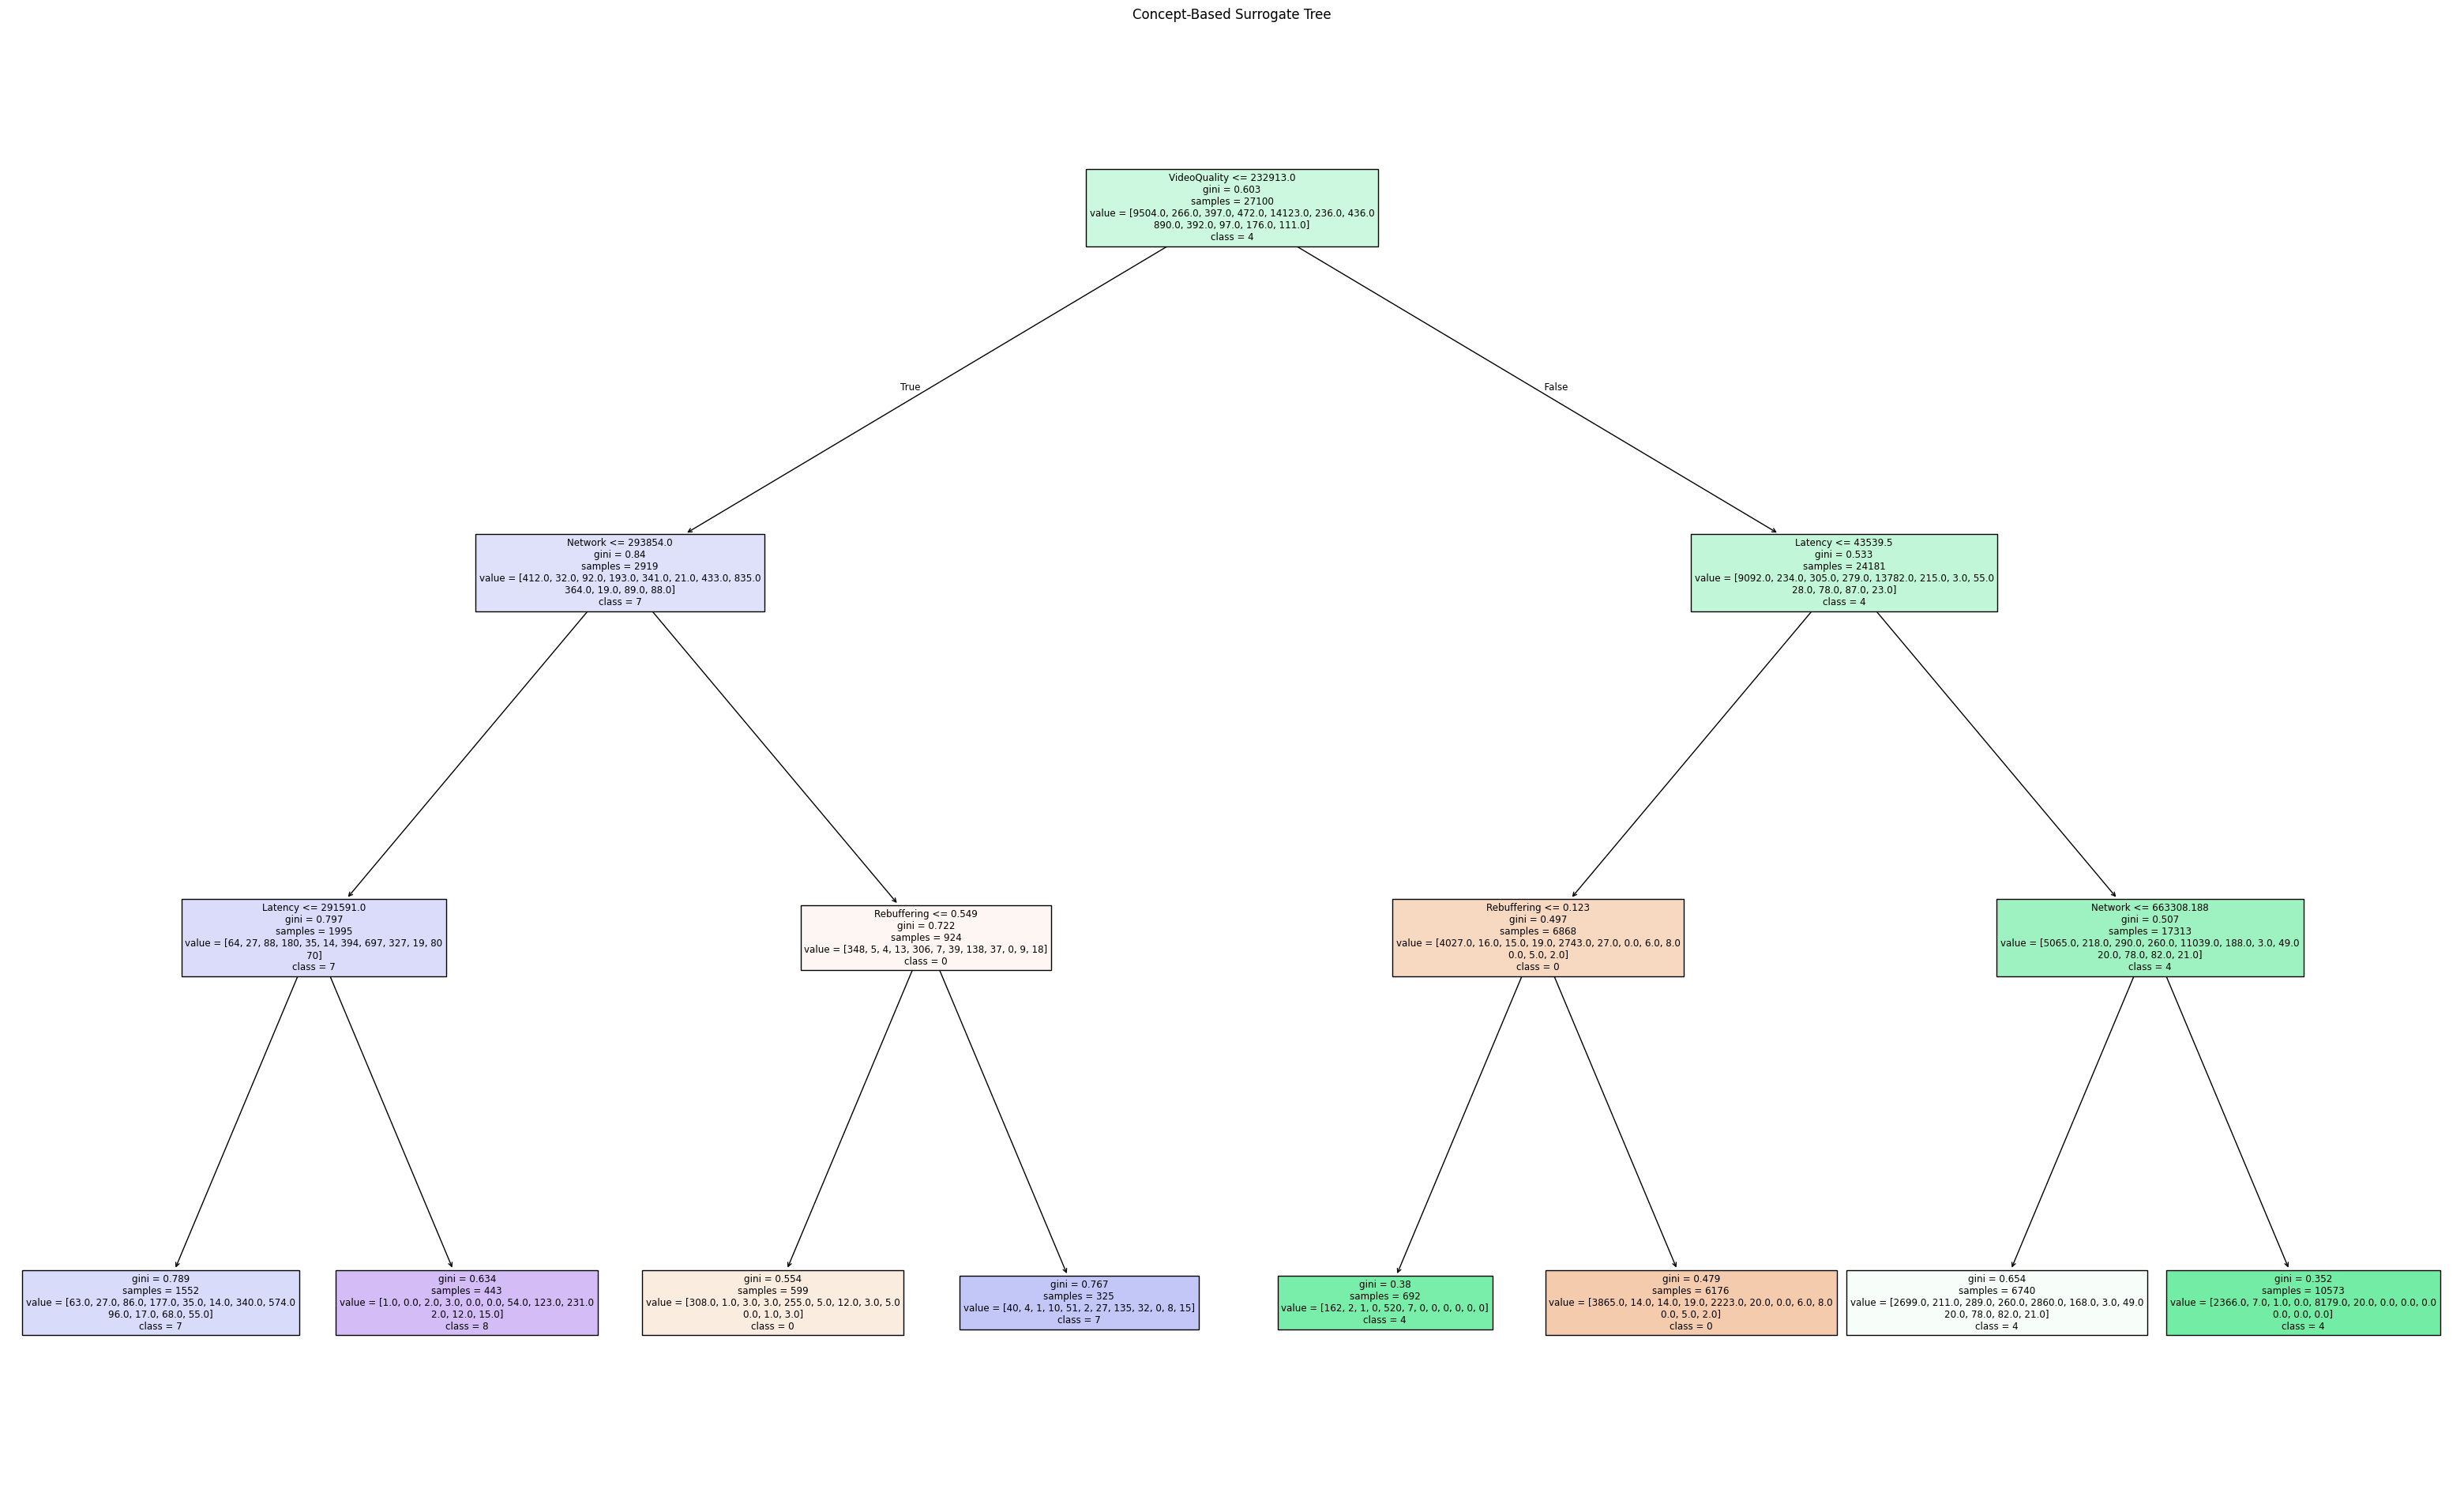

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a small decision tree on concept features
surrogate = DecisionTreeClassifier(max_depth=3, random_state=0)
surrogate.fit(X_test_concepts, y_test)

# Visualize the surrogate tree
plt.figure(figsize=(40, 24))
plot_tree(surrogate, 
          feature_names=X_test_concepts.columns, 
          filled=True, 
          class_names=[str(cls) for cls in sorted(y_test.unique())])
plt.title("Concept-Based Surrogate Tree")
plt.show()

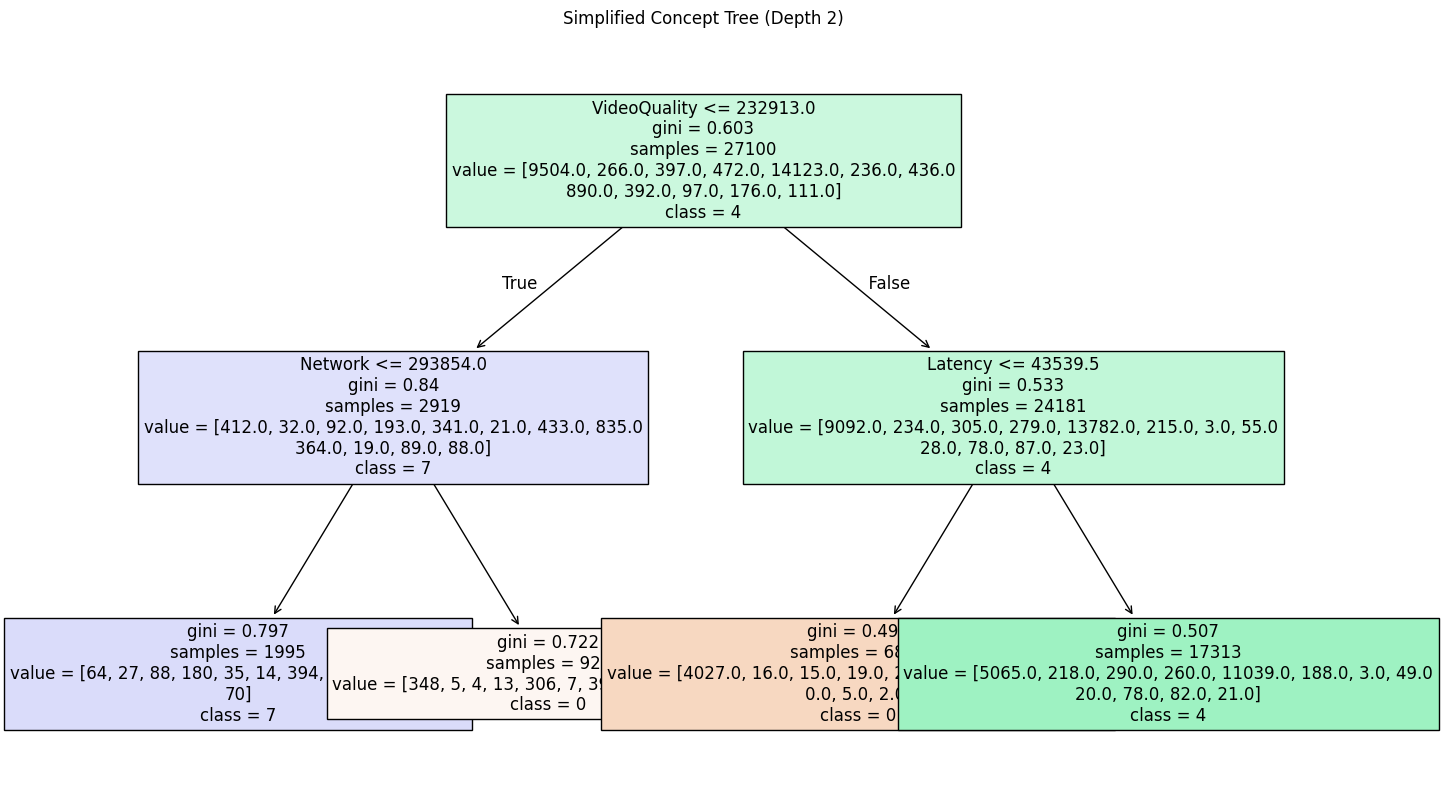

In [ ]:
simpler_tree = DecisionTreeClassifier(max_depth=2, random_state=0)
simpler_tree.fit(X_test_concepts, y_test)

plt.figure(figsize=(16, 10))
plot_tree(
    simpler_tree,
    feature_names=X_test_concepts.columns,
    filled=True,
    class_names=[str(cls) for cls in sorted(y_test.unique())],
    fontsize=12
)
plt.title("Simplified Concept Tree (Depth 2)")
plt.show()

ExactExplainer explainer: 1001it [00:25, 23.83it/s]                             
/var/folders/d9/210kwmkj07x7qlhkkmmnw4z80000gn/T/ipykernel_12939/141469809.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 0], X_sample_df)


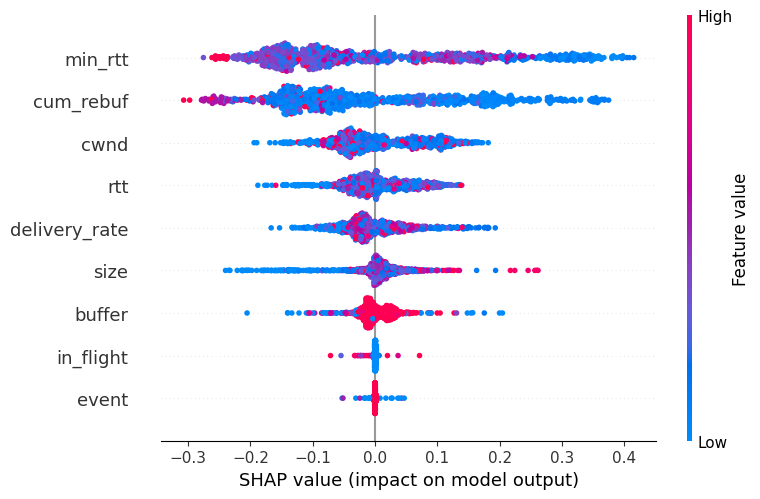

In [ ]:
import shap

# Sample and DataFrame
X_sample = X_train[:1000]
X_sample_df = pd.DataFrame(X_sample, columns=[
    'size', 'cwnd', 'in_flight', 'min_rtt', 'rtt',
    'delivery_rate', 'event', 'buffer', 'cum_rebuf'
])

# Create SHAP explainer
explainer = shap.Explainer(clf.predict_proba, X_sample_df)
shap_values = explainer(X_sample_df)

# Summary plot for class index 0
shap.summary_plot(shap_values.values[:, :, 0], X_sample_df)